In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
data_DIR = "../data/hppc/"
fig_DIR = "../figures/"
res_DIR = "../data/results/"

%matplotlib widget

In [2]:
spm = pybamm.lithium_ion.SPMe(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [3]:
parameter_values = get_parameter_values()

In [4]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")

In [5]:

parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": 1.2676e-07,#2.7081e-07, #4.1759e-07,#2.7081e-07, #2.5112e-07,
        "Negative electrode LAM constant proportional term [s-1]": 1.2713e-06,#3.7576e-06, #3.2693e-06,#3.7576e-06, #2.4741e-06,
        "Positive electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        "EC diffusivity [m2.s-1]": 8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)


In [6]:
hppc_data_raw = pd.read_csv(data_DIR+'hppc_data_cell_'+cell_no+'.csv')
hppc_data_raw = hppc_data_raw[ hppc_data_raw['Cycle number'] == 0 ]

In [7]:
hppc_data = hppc_data_raw.iloc[378:,:]
hppc_data = hppc_data.reset_index(drop=True)

In [8]:
data_time = hppc_data['Time [s]']-hppc_data['Time [s]'][0]
data_time = data_time.values
data_current = hppc_data['Current [mA]']/1000
data_current = data_current.values
data_voltage = hppc_data['Voltage [V]']
data_voltage = data_voltage.values

In [9]:
timescale = parameter_values.evaluate(spm.timescale)
current_interpolant = pybamm.Interpolant(
  #  drive_cycle[:, 0], drive_cycle[:, 1], timescale * pybamm.t
  data_time, -data_current, timescale * pybamm.t
)


In [10]:
parameter_values["Current function [A]"] = current_interpolant
sim = pybamm.Simulation(spm, parameter_values=parameter_values, solver=pybamm.CasadiSolver(mode="safe"))
sim.solve(t_eval=data_time,initial_soc =1)
solution = sim.solution

In [11]:
t = solution["Time [s]"].entries
V = solution["Terminal voltage [V]"].entries
I = solution["Current [A]"].entries
Q = -solution['Discharge capacity [A.h]'].entries

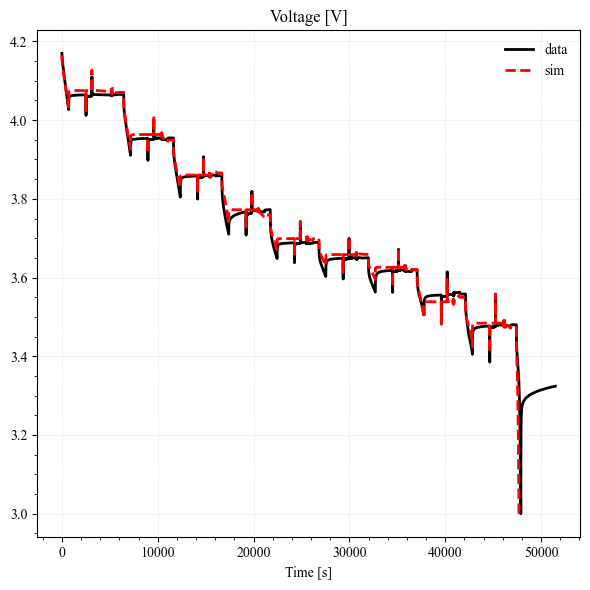

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6), sharex=True)
ax1.plot(data_time, data_voltage, 'k', t, V, 'r--')
ax1.set_title("Voltage [V]")
# ax1.set_ylim([3.9,4.12])
ax1.set_xlabel("Time [s]")
# ax1.set_xlim([20370,20470])
ax1.legend(['data','sim'])
fig.tight_layout()
plt.show()
plt.savefig('cell_01_hppc_fit.png')